# temperature differences

In this notebook, we compute the difference between the temperature mesured by the tag and the temperature from the reference model

**Summary:**

1. Opening the data: reference model (mars) and tag log
2. Set up the dask cluster
3. Data alignment
4. Compute the differences
5. Save to disk

In [1]:
import cf_xarray
import dask
import fsspec
import intake
import numba
import numpy as np
import pandas as pd
import xarray as xr

from pangeo_fish.cf import bounds_to_bins
from pangeo_fish.diff import marc_diff_z
from pangeo_fish.model import marc_sigma_to_depth
from pangeo_fish.tags import adapt_model_time, reshape_by_bins, to_time_slice

parametrize with [papermill](https://papermill.readthedocs.io/en/latest/)

In [2]:
tag_url: str

catalog: str
catalog_parameters: dict = {}

scheduler_address: str | None = None

relative_depth_threshold: float = 0.8

diff_path: str

# local PC
tag_url="/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/tag/nc/A18832.nc"
catalog = "https://data-taos.ifremer.fr/kerchunk/ref-copernicus.yaml"
scheduler_address: str | None = None
catalog = "https://data-taos.ifremer.fr/kerchunk/ref-marc.yaml"
diff_path="/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/A18832-f1_e2500/diff.zarr"


# Datarmor
tag_url="/home/datawork-lops-iaocea/data/fish-intel/tag/nc/A18832.nc"

# mars
catalog_mars = "/home/datawork-taos-s/intranet/kerchunk/ref-marc.yaml"
catalog_parameters: dict = {  "region": "f1_e2500",  "year": "2022"}
diff_path="/home/datawork-taos-s/public/fish/A18832-f1_e2500/diff.zarr"


# copernicus
catalog="/home/datawork-taos-s/intranet/kerchunk/ref-copernicus.yaml"
#catalog_parameters: dict = {  "type": ["2022_3D","2022_2D","mdt"]}
diff_path="/home/datawork-taos-s/public/fish/A18832-copernicus/diff.zarr"



cluster

In [3]:
import dask_hpcconfig
from distributed import Client

In [4]:
overrides = {}
# overrides = { "cluster.cores": 28 , "cluster.processes": 6 }

cluster = dask_hpcconfig.cluster("datarmor", **overrides)
client = Client(cluster)
cluster.scale(50)
client

/home1/datawork/todaka/micromamba/pangeo-fish-iaocea/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.102:8787/status,
Dashboard: http://10.148.1.102:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.102:58414,Workers: 0
Dashboard: http://10.148.1.102:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Open the data: reference model (mars) and tag log

open the tag log

In [5]:
tag = xr.open_dataset(fsspec.open(tag_url).open(), engine="h5netcdf").load()
tag

/home1/datawork/todaka/micromamba/pangeo-fish-iaocea/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home1/datawork/todaka/micromamba/pangeo-fish-iaocea/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:            (deployments: 1, timestamp: 7, mission_day: 81,
                        time: 77152, events: 3)
Coordinates:
  * deployments        (deployments) int64 0
  * timestamp          (timestamp) object '03/03/2022 10:55:00' ... '16/06/20...
  * mission_day        (mission_day) int64 0 1 2 3 4 5 6 ... 75 76 77 78 79 80
  * time               (time) datetime64[ns] 2022-06-17 ... 2022-09-05T08:46:30
  * events             (events) object 'release' 'recapture' 'tag_recovery'
    latitude           (events) float64 48.44 48.42 nan
    longitude          (events) float64 -4.907 -5.134 nan
    times              (events) datetime64[ns] 2022-06-17T11:01:00 ... NaT
Data variables: (12/19)
    start              (deployments) object '17/06/2022'
    stop               (deployments) object '08/12/2027'
    logging_rate       (deployments) int64 90
    sensors            (deployments) object 'P-T-'
    resolution         (deployments) int64 12
    fast_rate          (deployments) object 'Not Set'
    ...                 ...
    min_temp           (mission_day) float64 18.06 13.02 13.06 ... 13.58 22.27
    max_depth          (mission_day) float64 1.12 34.43 42.56 ... 66.62 1.37
    min_depth          (mission_day) float64 1.0 1.0 9.56 ... 9.31 1.18 0.68
    batt_volts         (mission_day) float64 3.1 3.09 3.09 ... 3.09 3.09 3.1
    pressure           (time) float64 1.06 1.06 1.06 1.06 ... 0.5 0.5 0.5 0.37
    water_temperature  (time) float64 18.06 18.06 18.06 ... 20.67 20.94 21.12
Attributes: (12/14)
    firmware_version_no:          3
    firmware_build_level:         80
    tag_id:                       A18832
    pressure_range:               20
    no_of_sensors:                2
    dive_termination_percentage:  1.5%
    ...                           ...
    start_time:                   17/06/2022 00:00:00
    stop_time:                    08/12/2027
    logging_rate:                 90
    resolution:                   12
    data_points_available:        77152
    block_number:                 0

open the reference model

TODO: for now, we will directly read the data, but in the future we might want to use [xpublish](https://github.com/xpublish-community/xpublish) to hide the reading / preprocessing of the reference model (especially computing the depth / pressure and stitching together different models)

In [6]:
cat = intake.open_catalog(catalog)
ds=cat.data_tmp(type="2022_3D").to_dask().rename({"thetao":"TEMP"})[["TEMP"]]
ds["XE"]=cat.data_tmp(type="2022_2D").to_dask().zos
ds["H0"]=cat.data_tmp(type="mdt").to_dask().deptho.rename({"latitude":"lat","longitude":"lon"})
ds["mask"]=cat.data_tmp(type="mdt").to_dask().mask.rename({"latitude":"lat","longitude":"lon"})

ds=ds.assign_coords(time=lambda ds: ds.time.astype("datetime64[ns]"))
ds

<xarray.Dataset>
Dimensions:  (time: 2208, depth: 33, lat: 1240, lon: 958)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 -16.0 -15.97 -15.94 -15.91 ... 12.91 12.94 12.97 13.0
  * time     (time) datetime64[ns] 2022-06-01T01:00:00 ... 2022-09-01
Data variables:
    TEMP     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 11, 414, 320), meta=np.ndarray>
    XE       (time, lat, lon) float32 dask.array<chunksize=(1, 1240, 958), meta=np.ndarray>
    H0       (lat, lon) float32 dask.array<chunksize=(620, 479), meta=np.ndarray>
    mask     (depth, lat, lon) float32 dask.array<chunksize=(33, 1240, 958), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2022-06-30T06:41:32Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous horizontal velocity (3D)

## data alignment

In order to compare measured temperature with the model, we need to
1. align time ranges
2. calculate the modelled depth
3. group the measured data into bins

### align time ranges

In [7]:
slice_ = to_time_slice(tag.times)

In [8]:
tag_log = tag.sel(time=slice_)
tag_log

<xarray.Dataset>
Dimensions:            (deployments: 1, timestamp: 7, mission_day: 81,
                        time: 74868, events: 3)
Coordinates:
  * deployments        (deployments) int64 0
  * timestamp          (timestamp) object '03/03/2022 10:55:00' ... '16/06/20...
  * mission_day        (mission_day) int64 0 1 2 3 4 5 6 ... 75 76 77 78 79 80
  * time               (time) datetime64[ns] 2022-06-17T11:01:30 ... 2022-09-...
  * events             (events) object 'release' 'recapture' 'tag_recovery'
    latitude           (events) float64 48.44 48.42 nan
    longitude          (events) float64 -4.907 -5.134 nan
    times              (events) datetime64[ns] 2022-06-17T11:01:00 ... NaT
Data variables: (12/19)
    start              (deployments) object '17/06/2022'
    stop               (deployments) object '08/12/2027'
    logging_rate       (deployments) int64 90
    sensors            (deployments) object 'P-T-'
    resolution         (deployments) int64 12
    fast_rate          (deployments) object 'Not Set'
    ...                 ...
    min_temp           (mission_day) float64 18.06 13.02 13.06 ... 13.58 22.27
    max_depth          (mission_day) float64 1.12 34.43 42.56 ... 66.62 1.37
    min_depth          (mission_day) float64 1.0 1.0 9.56 ... 9.31 1.18 0.68
    batt_volts         (mission_day) float64 3.1 3.09 3.09 ... 3.09 3.09 3.1
    pressure           (time) float64 1.81 1.87 1.93 1.81 ... 59.62 59.62 60.81
    water_temperature  (time) float64 14.61 14.61 14.61 ... 14.06 14.06 14.06
Attributes: (12/14)
    firmware_version_no:          3
    firmware_build_level:         80
    tag_id:                       A18832
    pressure_range:               20
    no_of_sensors:                2
    dive_termination_percentage:  1.5%
    ...                           ...
    start_time:                   17/06/2022 00:00:00
    stop_time:                    08/12/2027
    logging_rate:                 90
    resolution:                   12
    data_points_available:        77152
    block_number:                 0

In [9]:
#subset with time
model_subset = ds.sel(time=adapt_model_time(slice_))
#take out the depths where fish will never go.
depth_max=(tag_log.pressure.max() - model_subset.XE.min()).compute()
model_subset=model_subset.sel(depth=slice(0,depth_max))

#subset with location(iroise ocean) for quick computational tests
model_subset=model_subset.sel(lat=slice(45,51),lon=slice(-8,0))#.H0.plot()
model_subset

<xarray.Dataset>
Dimensions:  (time: 1814, depth: 13, lat: 371, lon: 264)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 ... 40.0 50.0 60.0 75.0 100.0
  * lat      (lat) float32 46.0 46.01 46.03 46.04 ... 50.96 50.97 50.99 51.0
  * lon      (lon) float32 -8.0 -7.97 -7.939 ... -0.09091 -0.06061 -0.0303
  * time     (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
Data variables:
    TEMP     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 11, 371, 56), meta=np.ndarray>
    XE       (time, lat, lon) float32 dask.array<chunksize=(1, 371, 264), meta=np.ndarray>
    H0       (lat, lon) float32 dask.array<chunksize=(371, 215), meta=np.ndarray>
    mask     (depth, lat, lon) float32 dask.array<chunksize=(13, 371, 264), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2022-06-30T06:41:32Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous horizontal velocity (3D)

### Convert sigma level to depth

The formula for the computation of the depth is model-specific.

*TODO*:
- calculate the modelled pressure and use that to compute the diff – essentially, that's what the tag measured
- have the hosted model (using `xpublish`) calculate the depth – that way, we don't need to worry about the model-specific formula

In [10]:
reference_model_=model_subset.rename({"depth":"level"}).chunk({"level": -1})
reference_model_['depth']=reference_model_.XE+reference_model_.level
reference_model_['bottom']=reference_model_.XE+reference_model_.H0



In [11]:
#set  coordinates to have 2 D coordinate system

broadcasted, = xr.broadcast(
    reference_model_[["lat","lon"]].reset_index(["lat","lon"]).rename_vars(
        {"lat":"latitude","lon":"longitude"}).reset_coords())
reference_model_=reference_model_.merge(broadcasted).set_coords(["latitude","longitude"])

In [12]:
reference_model = reference_model_.cf.add_bounds(["time"], output_dim="bounds").pipe(
    bounds_to_bins, bounds_dim="bounds"
)
reference_model

<xarray.Dataset>
Dimensions:      (time: 1814, level: 13, lat: 371, lon: 264, bounds: 2)
Coordinates:
  * level        (level) float32 0.0 3.0 5.0 10.0 15.0 ... 50.0 60.0 75.0 100.0
  * lat          (lat) float32 46.0 46.01 46.03 46.04 ... 50.96 50.97 50.99 51.0
  * lon          (lon) float32 -8.0 -7.97 -7.939 ... -0.09091 -0.06061 -0.0303
  * time         (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
    latitude     (lat, lon) float32 46.0 46.0 46.0 46.0 ... 51.0 51.0 51.0 51.0
    longitude    (lat, lon) float32 -8.0 -7.97 -7.939 ... -0.06061 -0.0303
    time_bounds  (time, bounds) datetime64[ns] 2022-06-17T10:30:00 ... 2022-0...
    time_bins    (time) object (2022-06-17 10:30:00, 2022-06-17 11:30:00] ......
Dimensions without coordinates: bounds
Data variables:
    TEMP         (time, level, lat, lon) float32 dask.array<chunksize=(1, 13, 371, 56), meta=np.ndarray>
    XE           (time, lat, lon) float32 dask.array<chunksize=(1, 371, 264), meta=np.ndarray>
    H0           (lat, lon) float32 dask.array<chunksize=(371, 215), meta=np.ndarray>
    mask         (level, lat, lon) float32 dask.array<chunksize=(13, 371, 264), meta=np.ndarray>
    depth        (time, lat, lon, level) float32 dask.array<chunksize=(1, 371, 264, 13), meta=np.ndarray>
    bottom       (time, lat, lon) float32 dask.array<chunksize=(1, 371, 215), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2022-06-30T06:41:32Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous horizontal velocity (3D)

### reshape the tag data

To further align both datasets, we need to reshape the data into bins, such that the `temperature(measured_time)` and `depth(measured_time)` coordinates become `temperature(model_time, obs)` and `depth(model_time, obs)`.

determine the bins

reshape

In [13]:
%%time
reshaped_tag = (
    tag_log[["water_temperature", "pressure"]]
    .pipe(
        reshape_by_bins,
        dim="time",
        bins=reference_model.time_bins,
        bin_dim="bincount",
        other_dim="obs",
    )
    .assign_coords(time=lambda ds: reference_model.time.isel(time=ds.bincount))
    .swap_dims({"bincount": "time"})
    .drop_vars(["bincount", "time_bins"])
    .chunk({"time": 1})
)
reshaped_tag

CPU times: user 5.28 s, sys: 108 ms, total: 5.39 s
Wall time: 5.28 s


<xarray.Dataset>
Dimensions:            (obs: 40, time: 1814)
Coordinates:
  * obs                (obs) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
  * time               (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
Data variables:
    water_temperature  (time, obs) float64 dask.array<chunksize=(1, 40), meta=np.ndarray>
    pressure           (time, obs) float64 dask.array<chunksize=(1, 40), meta=np.ndarray>
Attributes: (12/14)
    firmware_version_no:          3
    firmware_build_level:         80
    tag_id:                       A18832
    pressure_range:               20
    no_of_sensors:                2
    dive_termination_percentage:  1.5%
    ...                           ...
    start_time:                   17/06/2022 00:00:00
    stop_time:                    08/12/2027
    logging_rate:                 90
    resolution:                   12
    data_points_available:        77152
    block_number:                 0

## compute the differences

Now that both datasets are aligned, we can compute the actual difference. However, since the model's depth is a function of time and position, we can't just subtract the tag log from the model. Instead, we have to find the matching depth for each pixel separately, take the temperature at that depth and calculate the difference. Finally, we can compute the mean along the observation dimension to get a single value per pixel and timestep.

In [14]:
%%time
diff = (
    marc_diff_z(reference_model, reshaped_tag, depth_threshold=relative_depth_threshold)
    .to_dataset()
    .assign_attrs({"tag_id": tag_log.attrs["tag_id"]})
    .assign({"H0": reference_model.H0})
    .chunk({"time": 1,"lat":-1,"lon":-1})
)
diff

CPU times: user 528 ms, sys: 4 ms, total: 532 ms
Wall time: 527 ms


<xarray.Dataset>
Dimensions:    (lat: 371, lon: 264, time: 1814)
Coordinates:
  * lat        (lat) float32 46.0 46.01 46.03 46.04 ... 50.96 50.97 50.99 51.0
  * lon        (lon) float32 -8.0 -7.97 -7.939 ... -0.09091 -0.06061 -0.0303
  * time       (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
    latitude   (lat, lon) float32 dask.array<chunksize=(371, 264), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(371, 264), meta=np.ndarray>
    time_bins  (time) object dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    diff       (time, lat, lon) float32 dask.array<chunksize=(1, 371, 264), meta=np.ndarray>
    H0         (lat, lon) float32 dask.array<chunksize=(371, 264), meta=np.ndarray>
Attributes:
    tag_id:   A18832

## Save the differences to disk

In [15]:
%%time
# need to drop the bins since zarr cannot represent that
diff.drop_vars(["time_bins"]).to_zarr(diff_path, mode="w", consolidated=True)

CPU times: user 56.5 s, sys: 3.38 s, total: 59.8 s
Wall time: 1min 5s


In [16]:
import xarray as xr
diff_=xr.open_zarr(diff_path)


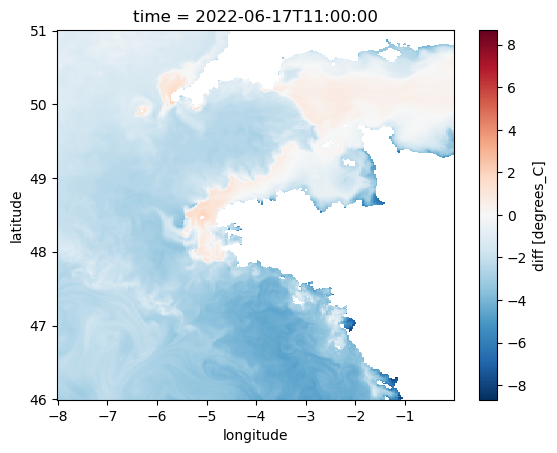

In [18]:
import hvplot.xarray
diff_['diff'].isel(time=0).plot(x='longitude',y='latitude')